In [1]:
#Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from plotnine import ggplot, aes, geom_line
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

#Dataset Import

In [2]:
#Pick Up Data
df=pd.read_csv('data_final.csv')
df.head(1)

,Unnamed: 0,timestamp,A.I. Virtasen aukio,"Aalto-yliopisto (M), Korkeakouluaukio","Aalto-yliopisto (M), Tietotie",Abraham Wetterin tie,Agnetankuja,Agronominkatu,Ahertajantie,Alakiventie,...,Viikin normaalikoulu,Viikin tiedepuisto,Viiskulma,Vilhonvuorenkatu,Voikukantie,Von Daehnin katu,Westendinasema,Westendintie,Yhdyskunnankuja,Ympyrätalo
0,0,2016-05-02 15:00:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [3]:
#Weather Data
de=pd.read_csv('weather_data.csv')
de.head(1)

,Unnamed: 0,timestamp,temp,dew,humidity,precip,windspeed,cloudcover,visibility,solarenergy
0,0,2016-05-02 15:00:00,15.3,0.4,36.28,0.0,9.2,0.1,29.4,2.1


#Data Set Functioning and Merge

Pickup data exploration

In [4]:
# Create 3 new columns
df['year']=df.timestamp.apply(lambda x:x[0:4])
df["month"]=df.timestamp.apply(lambda x: x[5:7])
df["day"]=df.timestamp.apply(lambda x: x[8:10])
#call new Data Frame
df1=df
df1.head(1)

,Unnamed: 0,timestamp,A.I. Virtasen aukio,"Aalto-yliopisto (M), Korkeakouluaukio","Aalto-yliopisto (M), Tietotie",Abraham Wetterin tie,Agnetankuja,Agronominkatu,Ahertajantie,Alakiventie,...,Vilhonvuorenkatu,Voikukantie,Von Daehnin katu,Westendinasema,Westendintie,Yhdyskunnankuja,Ympyrätalo,year,month,day
0,0,2016-05-02 15:00:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2016,05,02


In [5]:
#Delete Coulmn from original dataset
df1.drop(["Unnamed: 0","timestamp"],axis=1,inplace=True)
#Call New dataframe with groupby
df2=df1.groupby(["year","month","day"]).sum()
df2.head(2)

A.I. Virtasen aukio  Aalto-yliopisto (M), Korkeakouluaukio  \
year month day                                                               
2016 05    02                     0                                      0   
           03                     0                                      0   

                Aalto-yliopisto (M), Tietotie  Abraham Wetterin tie  \
year month day                                                        
2016 05    02                               0                     0   
           03                               0                     0   

                Agnetankuja  Agronominkatu  Ahertajantie  Alakiventie  \
year month day                                                          
2016 05    02             0              0             0            0   
           03             0              0             0            0   

                Albertinkatu  Annankatu  ...  Viikin normaalikoulu  \
year month day                           ...                         
2016 05    02              0          0  ...                     0   
           03              0          0  ...                     0   

                Viikin tiedepuisto  Viiskulma  Vilhonvuorenkatu  Voikukantie  \
year month day                                                                 
2016 05    02                    0          0                 0            0   
           03                    0         26                 0            0   

                Von Daehnin katu  Westendinasema  Westendintie  \
year month day                                                   
2016 05    02                  0               0             0   
           03                  0               0             0   

                Yhdyskunnankuja  Ympyrätalo  
year month day                               
2016 05    02                 0          37  
           03                 0          68  

[2 rows x 347 columns]

In [6]:
#Average Number of Pickup and reset index
df3=df2.agg("mean",axis=1)
df4=df3.to_frame(name="Average Number of Pickup")
df5=df4.reset_index()
df5.head(1)

,year,month,day,Average Number of Pickup
0,2016,05,02,1.573487


Weather Data Exploration


In [7]:
#Create 3 timestamp column on weather data
de['year']=de.timestamp.apply(lambda x:x[0:4])
de["month"]=de.timestamp.apply(lambda x: x[5:7])
de["day"]=de.timestamp.apply(lambda x: x[8:10])
de.drop(["Unnamed: 0"],axis=1,inplace=True)

In [8]:
#Call New dataframe with groupby and reset index
de1=de.groupby(["year","month","day"]).median()
de2=de1.reset_index()
de2.head(1)

,year,month,day,temp,dew,humidity,precip,windspeed,cloudcover,visibility,solarenergy
0,2016,05,02,14.8,-0.1,36.28,0.0,9.2,0.0,33.7,0.735487


Merge Datasets

In [9]:
#Merge Pickup and Weather data
merge_df = pd.merge(df5, de2, on=['year',	'month','day'], how='left').fillna(0)
merge_df.head(5)

,year,month,day,Average Number of Pickup,temp,dew,humidity,precip,windspeed,cloudcover,visibility,solarenergy
0,2016,05,02,1.573487,14.80,-0.10,36.280,0.0,9.20,0.0,33.70,0.735487
1,2016,05,03,4.487032,12.75,3.05,54.005,0.0,6.95,0.0,30.85,0.735487
2,2016,05,04,6.023055,16.30,2.20,37.900,0.0,8.30,0.0,29.45,0.735487
3,2016,05,05,6.158501,15.85,1.80,42.260,0.0,10.90,0.0,31.45,0.767744
4,2016,05,06,6.939481,15.45,1.35,38.770,0.0,12.20,0.0,31.95,0.767744


# **Visualization of Station and weather data**

In [10]:
#Yearly Average Pick Up Count
import plotly.express as px
fig = px.box(merge_df, x='year', y='Average Number of Pickup', color='year',
            title="Average Pickup Count by year",points="all")
fig.show()

In [22]:
#Monthly Average Pick Up Count
import plotly.express as px
fig = px.box(merge_df[merge_df["year"]=="2019"], x='month', y='Average Number of Pickup', color='year',
            title="Average Pickup Count by Month",points="all")
fig.show()

In [23]:
#Yearly Tempurature Count
import plotly.express as px
fig = px.box(merge_df, x='year', y='temp',color='year',title="Tempurature by year")
labels = ['2016', '2017', '2018','2019','2020']
fig.show()

In [24]:
#Yearlyly Humidity Count
import plotly.express as px
fig = px.box(merge_df, x='year', y='humidity',color='year',title="Humidity by year",points="all")
#labels = ['2016', '2017', '2018','2019','2020']
#fg.update_traces(textfont_size=12, textposition="bottom right")
fig.show()

In [26]:
#Yearly Windspeed Count
import plotly.express as px
fig = px.box(merge_df, x='year', y='windspeed',color='year',title="Windspeed by year",points="all")
labels = ['2016', '2017', '2018','2019','2020']
#fg.update_traces(textfont_size=12, textposition="bottom right")
fig.show()

In [28]:
#Yearly Solerenergy Count
import plotly.express as px
fig = px.box(merge_df, x='year', y='solarenergy',color='year',title="Solerenergy by year",points="all")
labels = ['2016', '2017', '2018','2019','2020']
#fg.update_traces(textfont_size=12, textposition="bottom right")
fig.show()

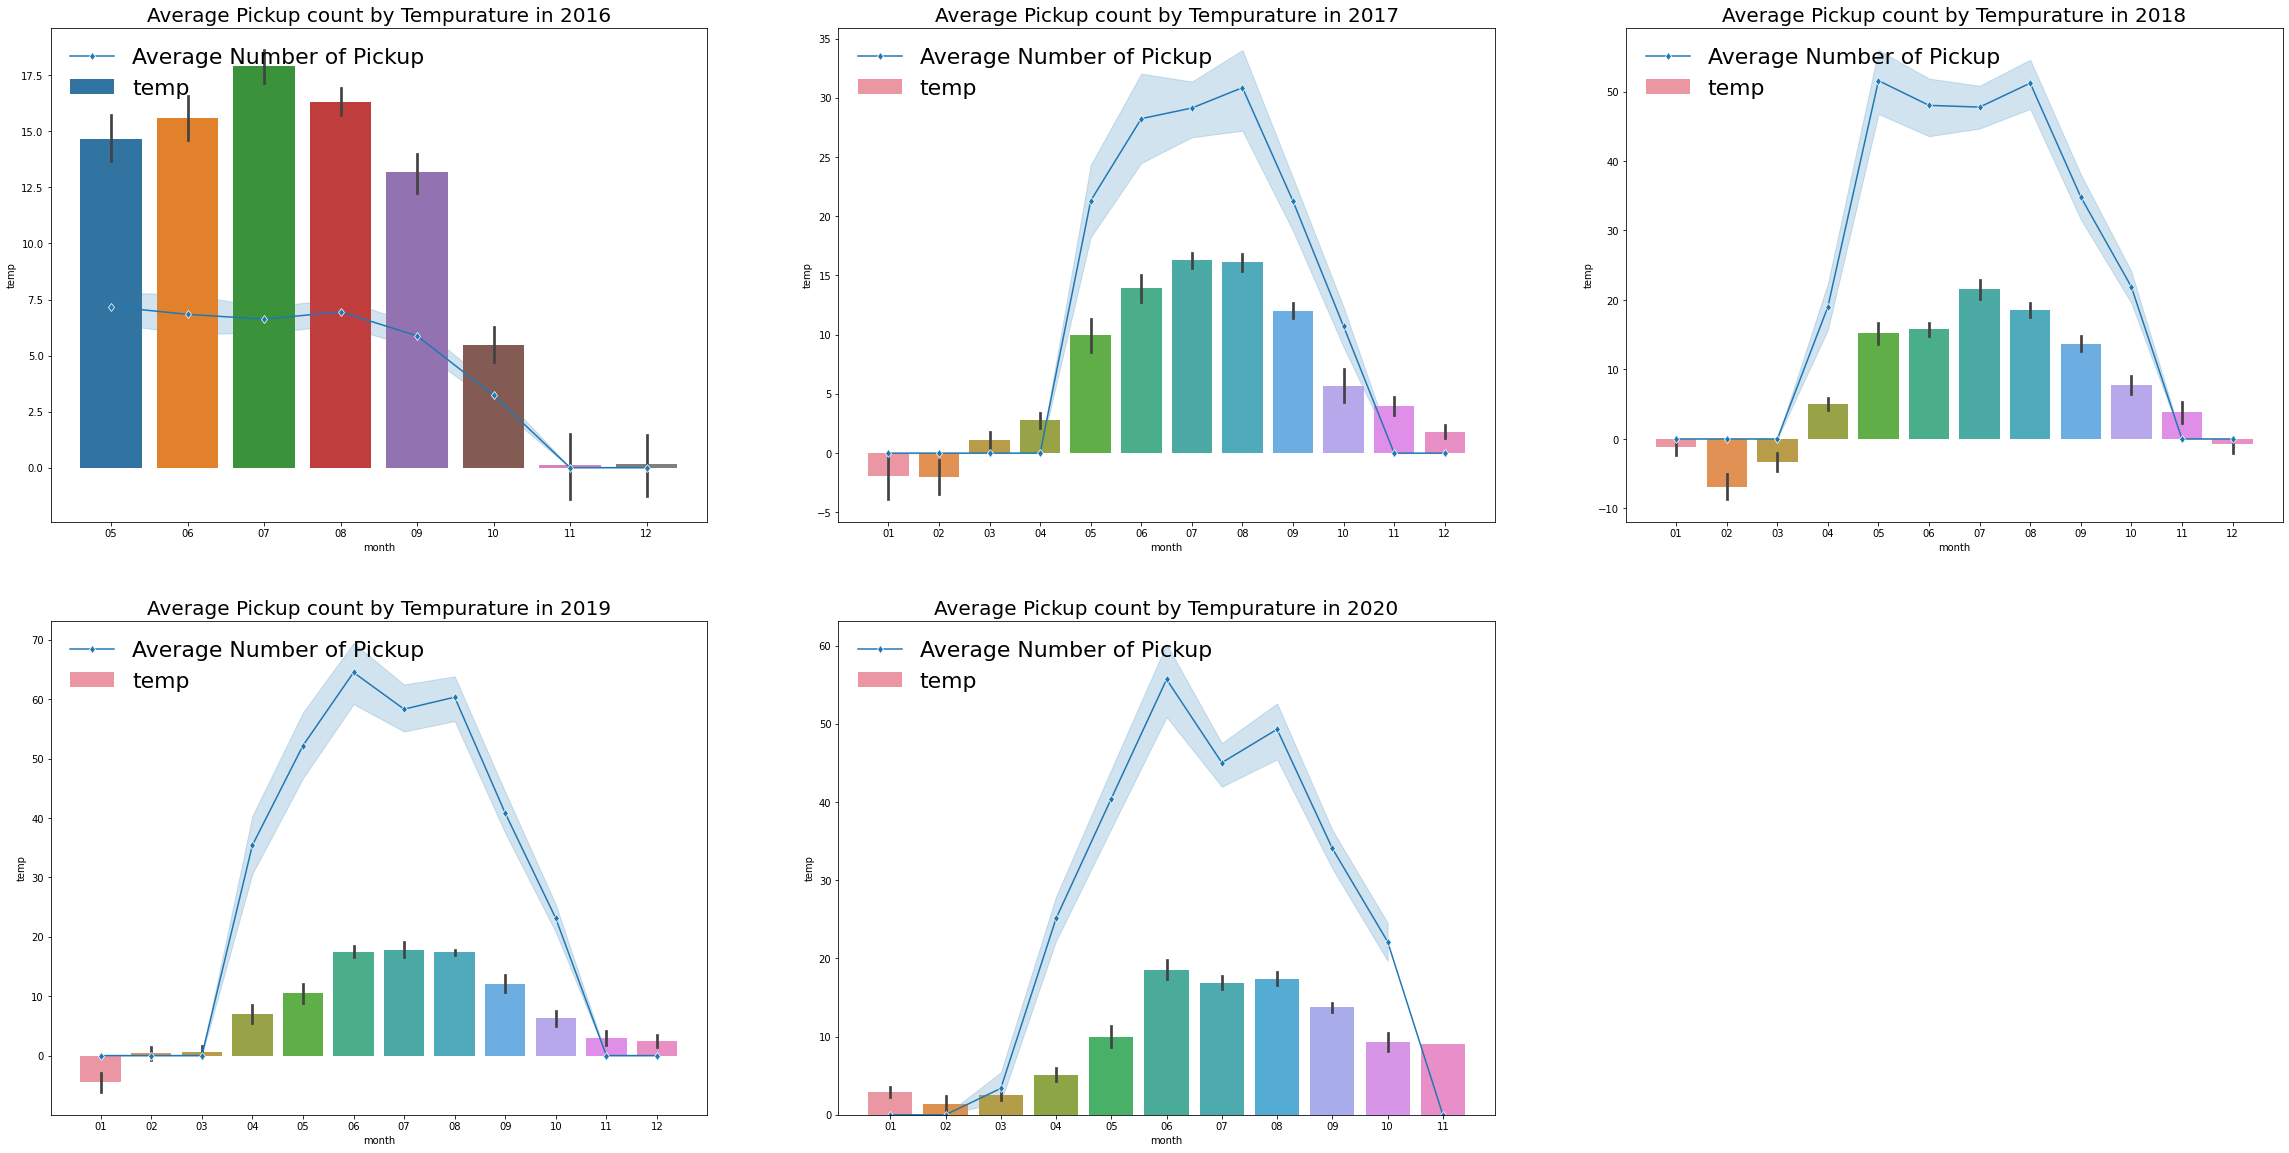

In [ ]:
#Average Pickup count by Tempurature in years.
plt.figure(figsize = (40,20)) # Adjusting figure size
ax1 = plt.subplot(2,3,1)
plt.title('Average Pickup count by Tempurature in 2016',fontsize = 20)
sns.barplot(x='month', y='temp', data=merge_df[merge_df["year"]=="2016"],ax=ax1,label='temp')
sns.lineplot(x='month',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2016"], marker='d', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=0,prop={'size': 22})
ax1 = plt.subplot(2,3,2)
plt.title('Average Pickup count by Tempurature in 2017',fontsize = 20)
sns.barplot(x='month', y='temp', data=merge_df[merge_df["year"]=="2017"],ax=ax1,label='temp')
sns.lineplot(x='month',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2017"], marker='d', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=0,prop={'size': 22})
ax1 = plt.subplot(2,3,3)
plt.title('Average Pickup count by Tempurature in 2018',fontsize = 20)
sns.barplot(x='month', y='temp', data=merge_df[merge_df["year"]=="2018"],label='temp')
sns.lineplot(x='month',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2018"], marker='d', label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})
ax1 = plt.subplot(2,3,4)
plt.title('Average Pickup count by Tempurature in 2019',fontsize = 20)
sns.barplot(x='month', y='temp', data=merge_df[merge_df["year"]=="2019"],ax=ax1,label='temp')
sns.lineplot(x='month',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2019"], marker='d', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})
ax1 = plt.subplot(2,3,5)
plt.title('Average Pickup count by Tempurature in 2020',fontsize = 20)
sns.barplot(x='month', y='temp', data=merge_df[merge_df["year"]=="2020"],ax=ax1,label='temp')
sns.lineplot(x='month',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2020"], marker='d', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})

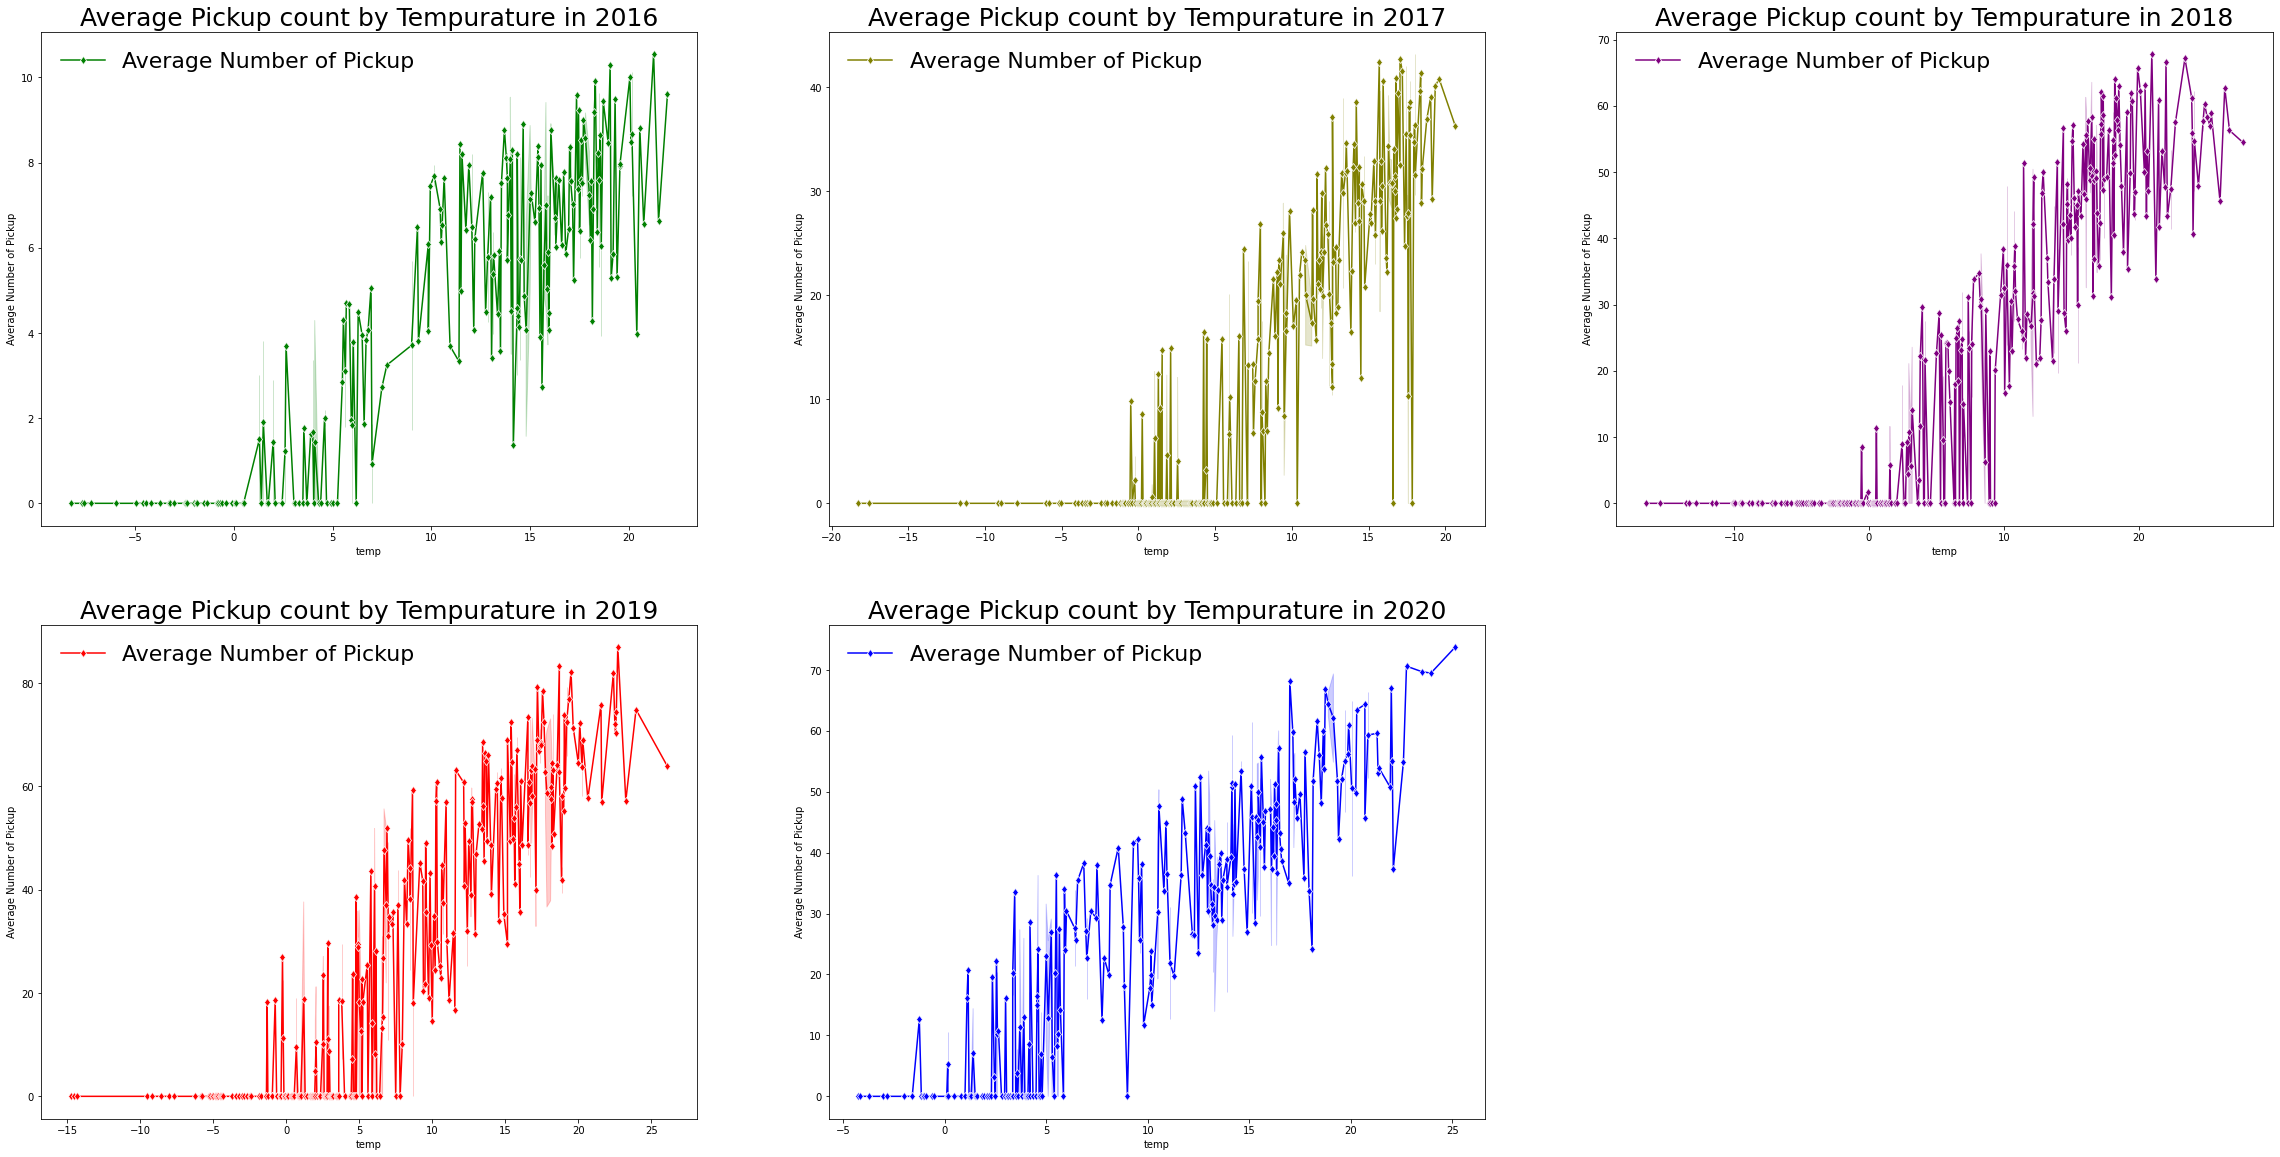

In [29]:
#Average Pickup count by Tempurature in years.
plt.figure(figsize = (40,20)) # Adjusting figure size
ax1 = plt.subplot(2,3,1)
plt.title('Average Pickup count by Tempurature in 2016',fontsize = 25)
sns.lineplot(x='temp',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2016"], marker='d',color='green',ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left',fontsize=18, frameon=False,framealpha=0,prop={'size': 22})
ax1 = plt.subplot(2,3,2)
plt.title('Average Pickup count by Tempurature in 2017',fontsize = 25)

sns.lineplot(x='temp',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2017"], marker='d',color='olive', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=0,prop={'size': 22})
ax1 = plt.subplot(2,3,3)
plt.title('Average Pickup count by Tempurature in 2018',fontsize = 25)

sns.lineplot(x='temp',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2018"], marker='d',color='purple', label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})
ax1 = plt.subplot(2,3,4)
plt.title('Average Pickup count by Tempurature in 2019',fontsize = 25)

sns.lineplot(x='temp',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2019"], marker='d',color='red', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})
ax1 = plt.subplot(2,3,5)
plt.title('Average Pickup count by Tempurature in 2020',fontsize = 25)

sns.lineplot(x='temp',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2020"], marker='d',color='blue', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})


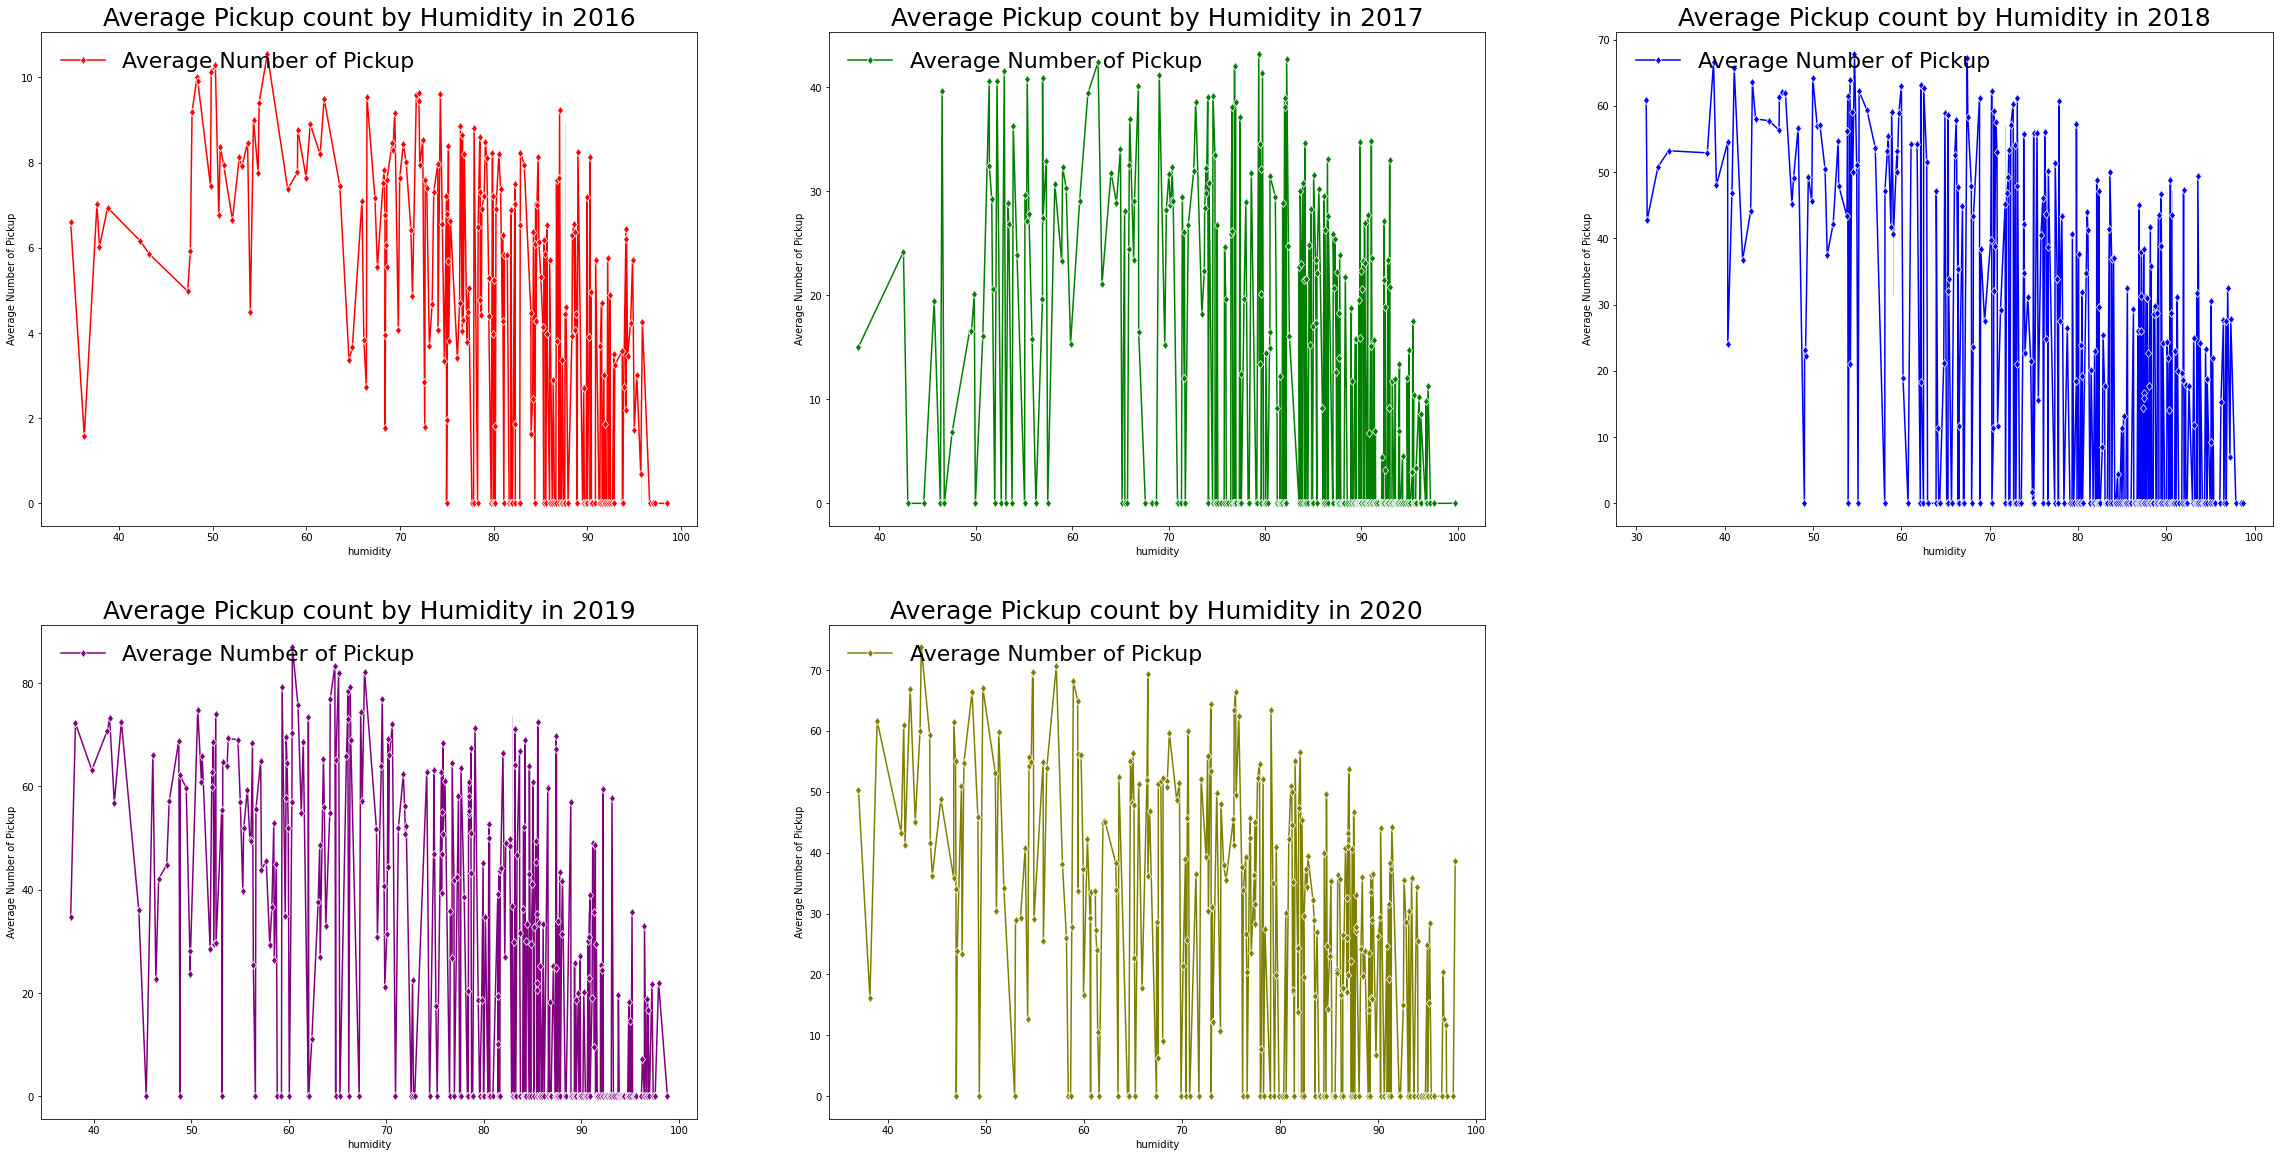

In [31]:
#Average Pickup count by Humidity in years.
plt.figure(figsize = (40,20)) # Adjusting figure size
ax1 = plt.subplot(2,3,1)
plt.title('Average Pickup count by Humidity in 2016',fontsize = 25)

sns.lineplot(x='humidity',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2016"], marker='d',color='red', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=0,prop={'size': 22})
ax1 = plt.subplot(2,3,2)
plt.title('Average Pickup count by Humidity in 2017',fontsize = 25)

sns.lineplot(x='humidity',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2017"], marker='d', color='green',ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=0,prop={'size': 22})
ax1 = plt.subplot(2,3,3)
plt.title('Average Pickup count by Humidity in 2018',fontsize = 25)

sns.lineplot(x='humidity',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2018"], marker='d', color='blue',label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})
ax1 = plt.subplot(2,3,4)
plt.title('Average Pickup count by Humidity in 2019',fontsize = 25)

sns.lineplot(x='humidity',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2019"], marker='d', color='purple',ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})
ax1 = plt.subplot(2,3,5)
plt.title('Average Pickup count by Humidity in 2020',fontsize = 25)

sns.lineplot(x='humidity',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2020"], marker='d',color='olive', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})

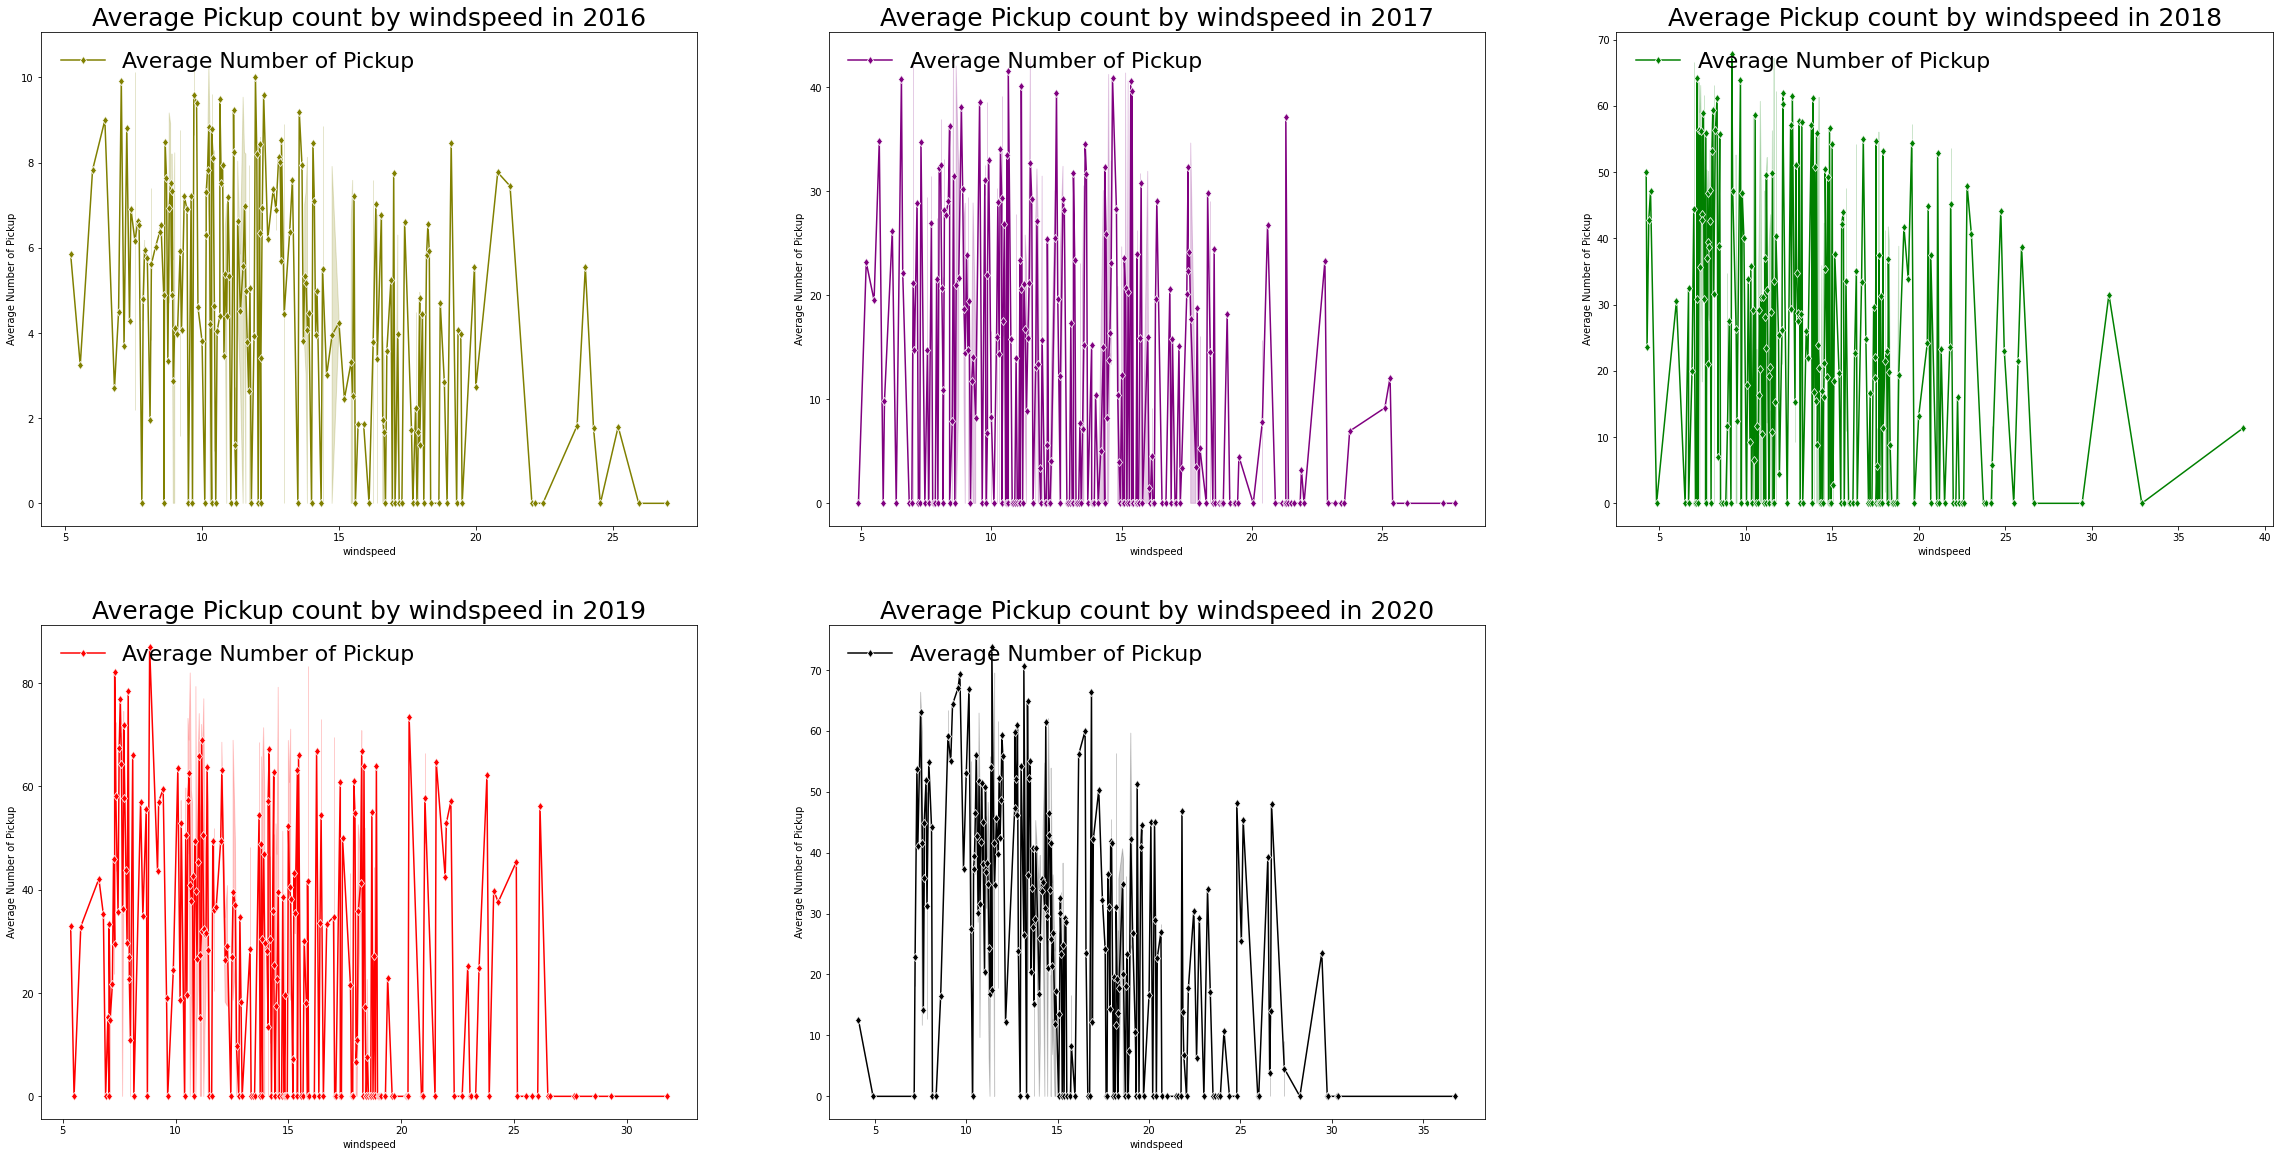

In [32]:
#Average Pickup count by Windspeed in years.
plt.figure(figsize = (40,20)) # Adjusting figure size
ax1 = plt.subplot(2,3,1)
plt.title('Average Pickup count by windspeed in 2016',fontsize = 25)

sns.lineplot(x='windspeed',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2016"], marker='d',color='olive', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=0,prop={'size': 22})
ax1 = plt.subplot(2,3,2)
plt.title('Average Pickup count by windspeed in 2017',fontsize = 25)

sns.lineplot(x='windspeed',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2017"], marker='d', color='purple',ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=0,prop={'size': 22})
ax1 = plt.subplot(2,3,3)
plt.title('Average Pickup count by windspeed in 2018',fontsize = 25)

sns.lineplot(x='windspeed',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2018"], marker='d',color='green', label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})
ax1 = plt.subplot(2,3,4)
plt.title('Average Pickup count by windspeed in 2019',fontsize = 25)

sns.lineplot(x='windspeed',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2019"], marker='d',color='red', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})
ax1 = plt.subplot(2,3,5)
plt.title('Average Pickup count by windspeed in 2020',fontsize = 25)

sns.lineplot(x='windspeed',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2020"], marker='d',color='black', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})

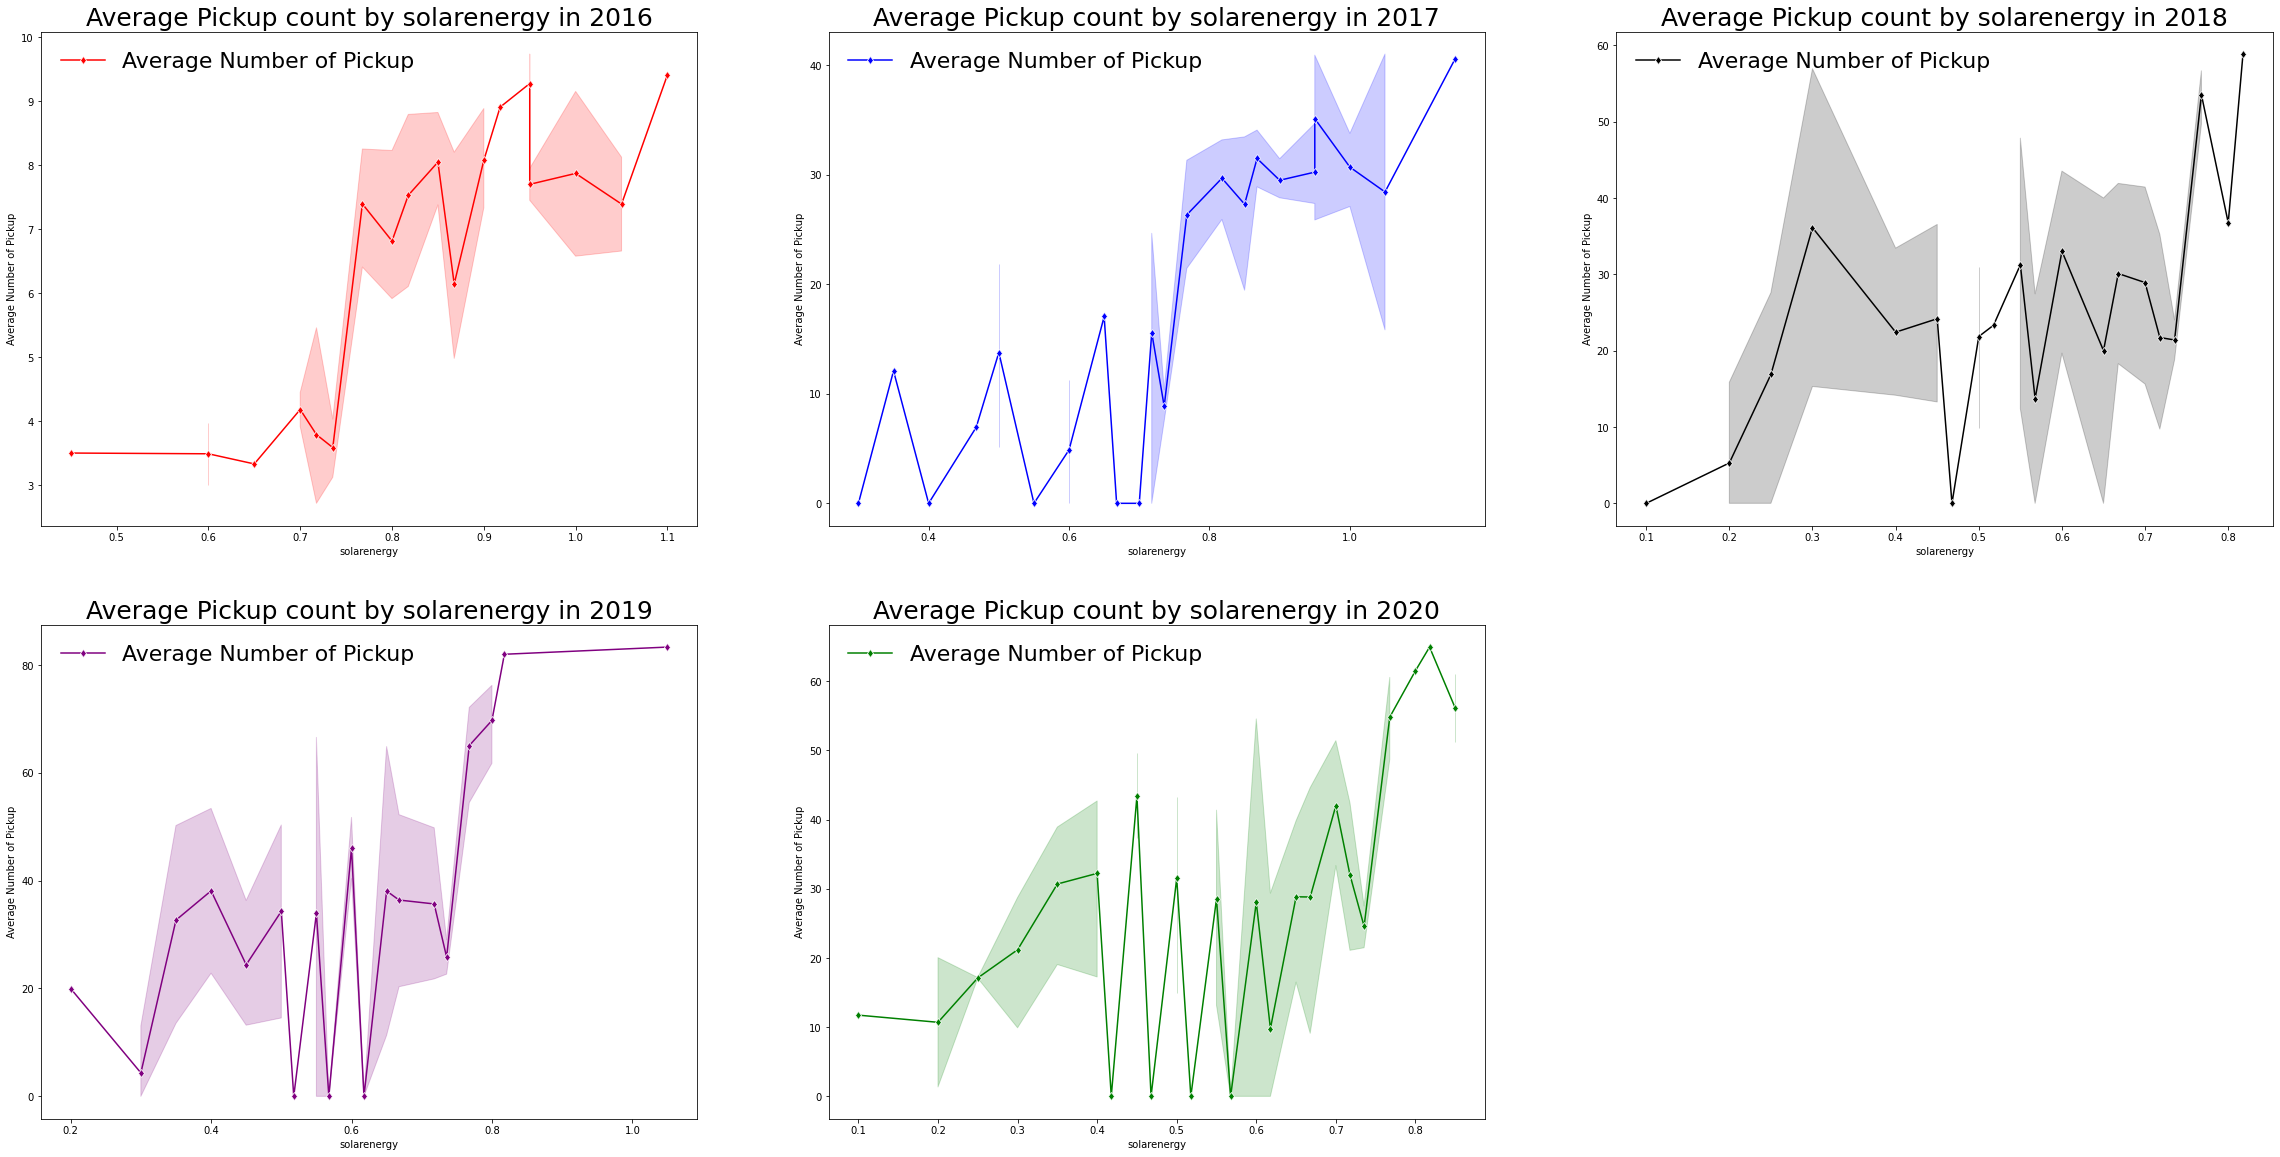

In [33]:
#Average Pickup count by solarenergy in years.
plt.figure(figsize = (40,20)) # Adjusting figure size
ax1 = plt.subplot(2,3,1)
plt.title('Average Pickup count by solarenergy in 2016',fontsize = 25)

sns.lineplot(x='solarenergy',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2016"], marker='d', color='red',ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=0,prop={'size': 22})
ax1 = plt.subplot(2,3,2)
plt.title('Average Pickup count by solarenergy in 2017',fontsize = 25)

sns.lineplot(x='solarenergy',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2017"], marker='d',color='blue', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=0,prop={'size': 22})
ax1 = plt.subplot(2,3,3)
plt.title('Average Pickup count by solarenergy in 2018',fontsize = 25)

sns.lineplot(x='solarenergy',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2018"], marker='d',color='black', label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})
ax1 = plt.subplot(2,3,4)
plt.title('Average Pickup count by solarenergy in 2019',fontsize = 25)

sns.lineplot(x='solarenergy',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2019"], marker='d',color='purple', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})
ax1 = plt.subplot(2,3,5)
plt.title('Average Pickup count by solarenergy in 2020',fontsize = 25)

sns.lineplot(x='solarenergy',y='Average Number of Pickup', data=merge_df[merge_df["year"]=="2020"], marker='d', color='green', ax=ax1,label='Average Number of Pickup')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 22})

#*Statistics Ploting-Autocorrelation and partial correlation*

Text(0.5, 1.0, 'Partial correlation of Tempurature')

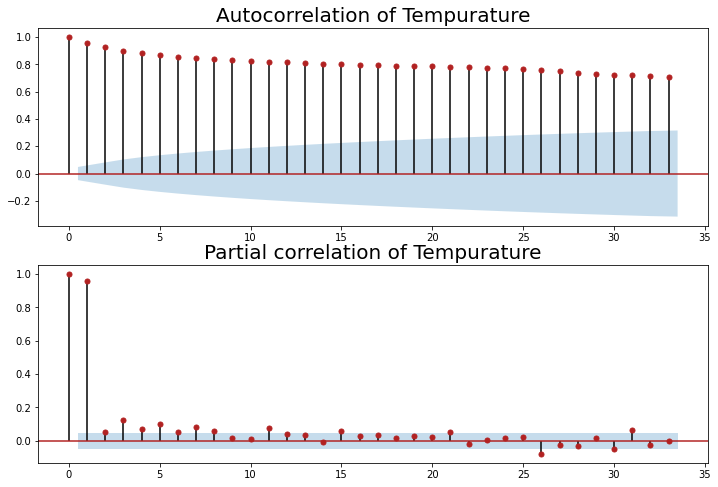

In [ ]:
#correlation and autocorrelation plots for tempurature
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(merge_df.temp, ax=ax1,color ='firebrick')
plt.title('Autocorrelation of Tempurature',fontsize = 20)
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 12})
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(merge_df.temp, ax=ax2,color='firebrick')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 12})
plt.title('Partial correlation of Tempurature',fontsize = 20)

Text(0.5, 1.0, 'Partial correlation of Humidity')

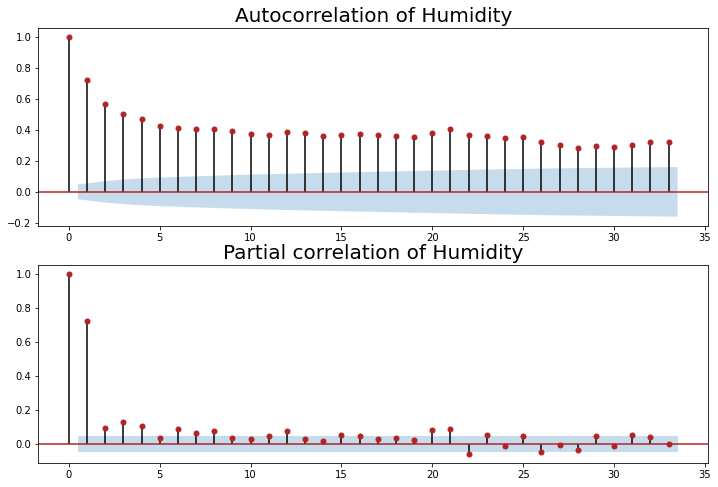

In [ ]:
#correlation and autocorrelation plots for Humidity
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(merge_df.humidity, ax=ax1,color ='firebrick')
plt.title('Autocorrelation of Humidity',fontsize = 20)
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 12})
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(merge_df.humidity, ax=ax2,color='firebrick')
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 12})
plt.title('Partial correlation of Humidity',fontsize = 20)

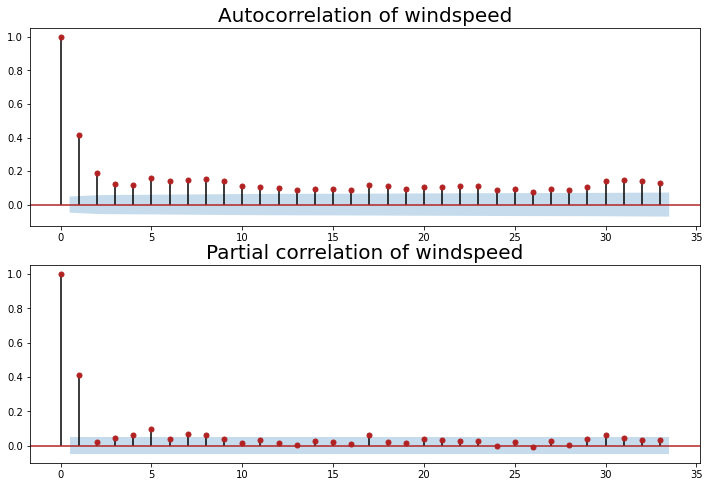

In [ ]:
#correlation and autocorrelation plots for windspeed
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(merge_df.windspeed, ax=ax1,color ='firebrick')
plt.title('Autocorrelation of windspeed',fontsize = 20)
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 12})
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(merge_df.windspeed, ax=ax2,color='firebrick')
plt.title('Partial correlation of windspeed',fontsize = 20)
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 12})

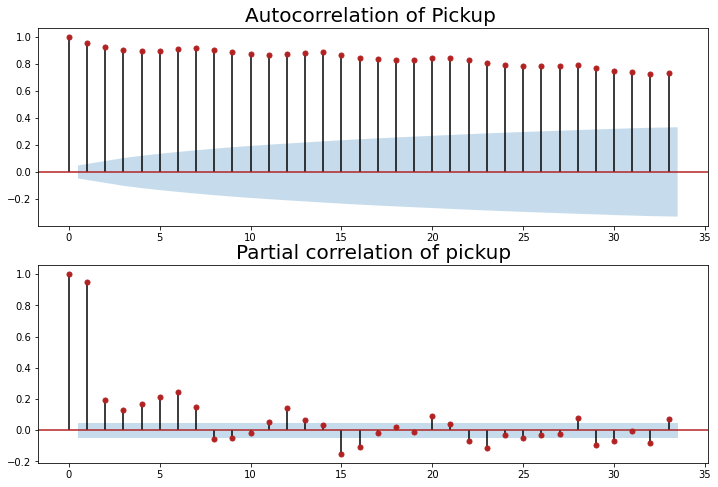

In [ ]:
#correlation and autocorrelation plots for Average Number of Pickup
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(merge_df['Average Number of Pickup'], ax=ax1,color ='firebrick')
plt.title('Autocorrelation of Pickup ',fontsize = 20)
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 12})
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(merge_df['Average Number of Pickup'], ax=ax2,color='firebrick')
plt.title('Partial correlation of pickup',fontsize = 20)
plt.legend(loc='upper left', frameon=False,framealpha=1,prop={'size': 12})

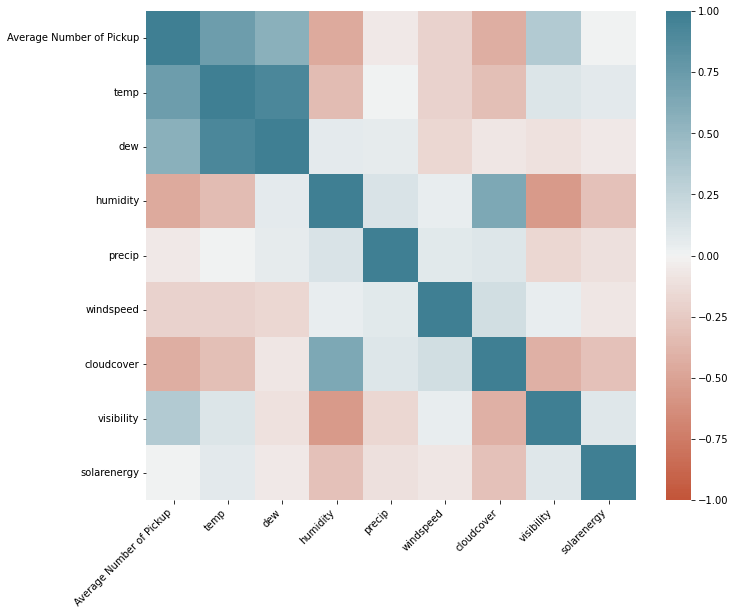

In [30]:
#Plotting Heatmap of Merge Dataset.
f, ax = plt.subplots(figsize=(11, 9))
corr = merge_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);